## STEP 1: Prepare the full dataset

In [23]:
import pandas as pd

teams = pd.read_csv("../data/Teams.csv")
teams = teams[teams["yearID"] >= 2000].copy()

# Feature engineering
teams["RunDiff"] = teams["R"] - teams["RA"]


## STEP 2: Define tiers using Training data

In [24]:
train_data = teams[teams["yearID"] <= 2021].copy()

q25 = train_data["W"].quantile(0.25)
q75 = train_data["W"].quantile(0.75)

def label_tier(w):
    if w >= q75:
        return "Contender"
    elif w <= q25:
        return "Rebuilding"
    else:
        return "Average"

teams["Tier"] = teams["W"].apply(label_tier)


## STEP 3: Split into train vs prediction periods

In [25]:
features = ["R", "RA", "HR", "BB", "SO"]

train_df = teams[teams["yearID"] <= 2021].dropna(subset=features + ["Tier"])
pred_df  = teams[teams["yearID"].between(2022, 2025)].dropna(subset=features)


## STEP 4: Encode labels and train classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

features = ["R", "RA", "HR", "BB", "SO"]

eval_df = teams[teams["yearID"] <= 2021].dropna(subset=features + ["Tier"])

X = eval_df[features]
y = eval_df["Tier"]

le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

val_pred = clf.predict(X_val)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [ ]:
print(classification_report(y_val, val_pred, target_names=le.classes_))


## STEP 5: Generate predictions for 2022–2025

In [27]:
X_pred = pred_df[features]
pred_labels = clf.predict(X_pred)
pred_probs = clf.predict_proba(X_pred)

pred_df["PredictedTier"] = le.inverse_transform(pred_labels)


## STEP 6: Results

In [28]:
results = pred_df[
    ["yearID", "teamID", "W", "PredictedTier"]
].sort_values(["yearID", "PredictedTier", "W"], ascending=[True, True, False])

results.head(15)




,yearID,teamID,W,PredictedTier
3501,2022,CLE,92,Average
3517,2022,SEA,90,Average
3516,2022,SDN,89,Average
3514,2022,PHI,87,Average
3509,2022,MIL,86,Average
3520,2022,TBA,86,Average
3496,2022,BAL,83,Average
3498,2022,CHA,81,Average
3518,2022,SFN,81,Average
3497,2022,BOS,78,Average


In [29]:
results.to_csv("../data/tier_predictions_2022_2025.csv", index=False)

In [31]:
tier_summary = (
    pred_df
    .groupby(["yearID", "PredictedTier"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

tier_summary


PredictedTier,yearID,Average,Contender,Rebuilding
0,2022,15,7,8
1,2023,11,13,6
2,2024,11,13,6
3,2025,14,10,6


In [32]:
tier_summary.to_csv("../data/tier_summary_2022_2025.csv", index=False)


## STEP 7: Confidence scores

In [30]:
import numpy as np

probs_df = pd.DataFrame(
    pred_probs,
    columns=[f"P_{c}" for c in le.classes_],
    index=pred_df.index
)

final_preds = pd.concat([results.reset_index(drop=True), probs_df.reset_index(drop=True)], axis=1)
final_preds.head()


,yearID,teamID,W,PredictedTier,P_Average,P_Contender,P_Rebuilding
0,2022,CLE,92,Average,0.913533,0.009354,7.711307e-02
1,2022,SEA,90,Average,0.009022,0.990978,1.974789e-07
2,2022,SDN,89,Average,0.921934,0.026998,5.106831e-02
3,2022,PHI,87,Average,0.897094,0.005533,9.737266e-02
4,2022,MIL,86,Average,0.840861,0.009326,1.498133e-01


## Step 8: Visualize

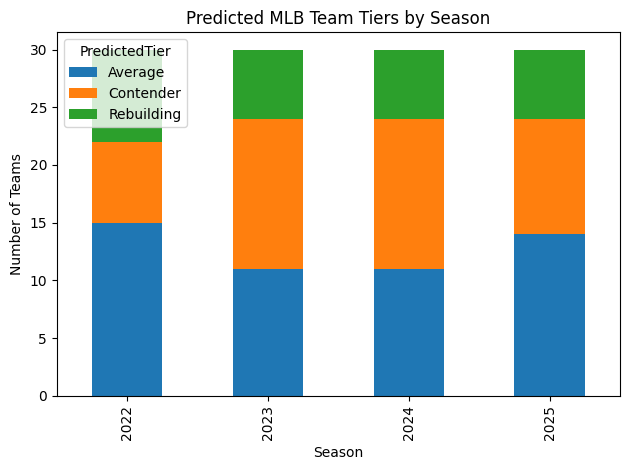

In [33]:
import matplotlib.pyplot as plt

tier_summary.set_index("yearID").plot(kind="bar", stacked=True)
plt.title("Predicted MLB Team Tiers by Season")
plt.xlabel("Season")
plt.ylabel("Number of Teams")
plt.tight_layout()
plt.savefig("../visuals/tier_distribution_by_year.png", dpi=200)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_val, val_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Validation Confusion Matrix (2000–2021)")
plt.tight_layout()
plt.savefig("../visuals/validation_confusion_matrix.png", dpi=200)
plt.show()


## Step 9: Specific Team

In [34]:
team_id = "ARI"

team_history = results[results["teamID"] == team_id].copy()
team_history.sort_values("yearID", inplace=True)

team_history


,yearID,teamID,W,PredictedTier
3494,2022,ARI,74,Average
3524,2023,ARI,84,Average
3554,2024,ARI,89,Contender
3584,2025,ARI,80,Average


In [35]:
tier_map = {
    "Rebuilding": 0,
    "Average": 1,
    "Contender": 2
}

team_history["TierNum"] = team_history["PredictedTier"].map(tier_map)


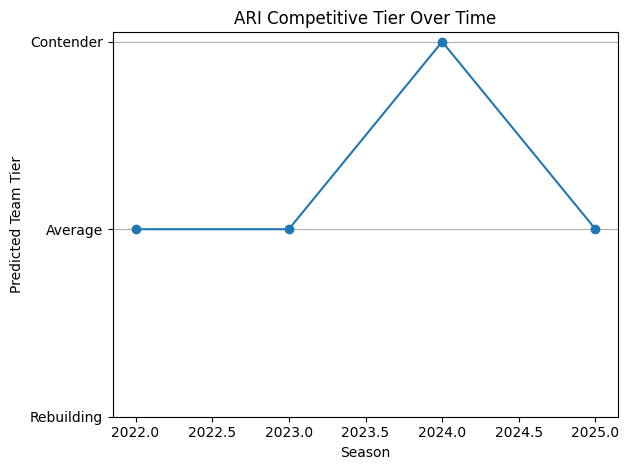

In [36]:
plt.figure()
plt.plot(team_history["yearID"], team_history["TierNum"], marker="o")
plt.yticks([0, 1, 2], ["Rebuilding", "Average", "Contender"])
plt.xlabel("Season")
plt.ylabel("Predicted Team Tier")
plt.title(f"{team_id} Competitive Tier Over Time")
plt.grid(True, axis="y")
plt.tight_layout()
plt.savefig(f"../visuals/{team_id}_tier_timeline.png", dpi=200)
plt.show()
